## Generate memory and cpu usage pattern from real jobs

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
import json
from six.moves.urllib.request import urlretrieve

In [2]:
from shutil import copyfile
url = 'http://orange.com/employee/wgmn4901/data/'
data_dir = "../data/"

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    if os.path.exists(data_dir+filename):
      #copy from data folder to working directory
      copyfile(data_dir+filename, filename)
    else:
      filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

clustersnapshot = maybe_download('clustersnapshot24022016.tar.gz', 249468)

Found and verified clustersnapshot24022016.tar.gz


In [3]:
def maybe_extract(filename,force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print('Found the following application profile in %s:' % filename)
  for folder in data_folders:
    print ('  %s' % folder)
  return data_folders
  
clustersnapshot_folders = maybe_extract(clustersnapshot)

clustersnapshot24022016 already present - Skipping extraction of clustersnapshot24022016.tar.gz.
Found the following application profile in clustersnapshot24022016.tar.gz:
  clustersnapshot24022016/application_1456319042576_0003_json
  clustersnapshot24022016/application_1456319042576_0004_json
  clustersnapshot24022016/application_1456319042576_0005_json
  clustersnapshot24022016/application_1456319042576_0006_json
  clustersnapshot24022016/application_1456319042576_0007_json


In [4]:
def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_task_list = []
  container_node_list = []
  container_node_mem_total_list = []
  container_node_CPU_total_list = []
  container_node_mem_rsrv_list = []
  container_node_CPU_rsrv_list = []
  container_mem_assigned_list = []
  container_CPU_assigned_list = []
  app_name_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_task = data["container_tasks"][0]["task_type"] #First task only
        app_name = data["application_info"]["appId"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoreAssigned"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
        container_node_mem_total_list.insert(container_index,container_node_mem_total)
        container_node_CPU_total_list.insert(container_index,container_node_CPU_total)
        container_node_mem_rsrv_list.insert(container_index,container_node_mem_rsrv)
        container_node_CPU_rsrv_list.insert(container_index,container_node_CPU_rsrv)
        container_mem_assigned_list.insert(container_index,container_mem_assigned)
        container_CPU_assigned_list.insert(container_index,container_CPU_assigned)
        app_name_list.insert(container_index,app_name)
      if not container_name:
        raise Exception('Unexpected container name')
      if container_starttime == 0:
        raise Exception('Unexpected container start time')
      if container_endtime == 0:
        raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,
                     container_task_list,container_node_list,container_node_mem_total_list,
                     container_node_CPU_total_list,container_node_mem_rsrv_list,container_node_CPU_rsrv_list,
                     container_mem_assigned_list, container_CPU_assigned_list, app_name_list))
  columns=[ 'start', 'end', 'task', 'node','n_mem','n_CPU',
                                    'mem_rsrv','CPU_rsrv','mem','CPU','app']
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  snapshot_dataframe = pd.DataFrame()
  for application_folder in snapshot_folders: 
    dataframe, application_starttime, application_endtime = load_application(application_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
  return snapshot_dataframe, snapshot_starttime, snapshot_endtime

In [5]:
snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))

SnapshotDFSorted = snapshot_dataframe.sort(columns="start")
SnapshotDFSorted

Snapshot start time: 1456334801869
Snapshot end time: 1456335271858
Snapshot duration: 469989 ms (or ~469 s or ~7 m)


,start,end,task,node,n_mem,n_CPU,mem_rsrv,CPU_rsrv,mem,CPU,app
container_e100_1456319042576_0003_01_000001,1456334801869,1456334956139,AM,null,0,0,0,0,0,0,application_1456319042576_0003
container_e100_1456319042576_0003_01_000007,1456334821284,1456334853323,MAP,svr15.spo:45454,8061476,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000018,1456334821302,1456334875859,MAP,svr08.spo:45454,8061480,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000019,1456334821303,1456334876786,MAP,svr08.spo:45454,8061480,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000005,1456334821305,1456334853278,MAP,svr15.spo:45454,8061476,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000006,1456334821306,1456334853294,MAP,svr15.spo:45454,8061476,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000027,1456334821402,1456334880555,MAP,svr14.spo:45454,8061480,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000028,1456334821438,1456334880480,MAP,svr14.spo:45454,8061480,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000029,1456334821443,1456334876825,MAP,svr14.spo:45454,8061480,4,6553600,6,2097152,1,application_1456319042576_0003
container_e100_1456319042576_0003_01_000008,1456334821494,1456334853344,MAP,svr13.spo:45454,8061476,4,6553600,6,2097152,1,application_1456319042576_0003


In [6]:
def load_application_cpu_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_load_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["cpu_usage"]:
          #print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["cpu_usage"]:
            container_capture_time = record["capture_time"]
            container_load = record["container_load"] / 100
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_load_list.insert(record_index,container_load)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_load_list))
  columns=[ 'timestamp','name','cpu_load']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_cpu_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_cpu_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_cpu_profile, snapshot_failcount = load_snapshot_cpu_profile(clustersnapshot_folders)
print ("Done! Loading %d profiles of %d containers, fail %d containers with no information" % 
       (len(snapshot_cpu_profile.name.unique()),
        len(snapshot_cpu_profile.name.unique()) + snapshot_failcount,
        snapshot_failcount))
snapshot_cpu_profile

Done! Loading 268 profiles of 323 containers, fail 55 containers with no information


,timestamp,name,cpu_load
0,1456334839,container_e100_1456319042576_0003_01_000033,1.917
1,1456334840,container_e100_1456319042576_0003_01_000033,2.156
2,1456334842,container_e100_1456319042576_0003_01_000033,0.958
3,1456334843,container_e100_1456319042576_0003_01_000033,1.697
4,1456334855,container_e100_1456319042576_0003_01_000043,1.019
5,1456334857,container_e100_1456319042576_0003_01_000043,1.138
6,1456334858,container_e100_1456319042576_0003_01_000043,1.038
7,1456334860,container_e100_1456319042576_0003_01_000043,0.879
8,1456334861,container_e100_1456319042576_0003_01_000043,1.058
9,1456334863,container_e100_1456319042576_0003_01_000043,1.218


In [7]:
def get_cpu_actual_use(container_name, snapshot_dataframe, snapshot_cpu_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  cpu_container_filtered = snapshot_cpu_profile[(snapshot_cpu_profile.name == container_name)]
  index = cpu_container_filtered.timestamp.tolist()
  cpu_load = cpu_container_filtered.cpu_load.tolist()
  container_data1 = pd.Series(cpu_load,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    #print(a) # to see match data point
    #raise Exception('Return length mismatch')
    
  return container_data4

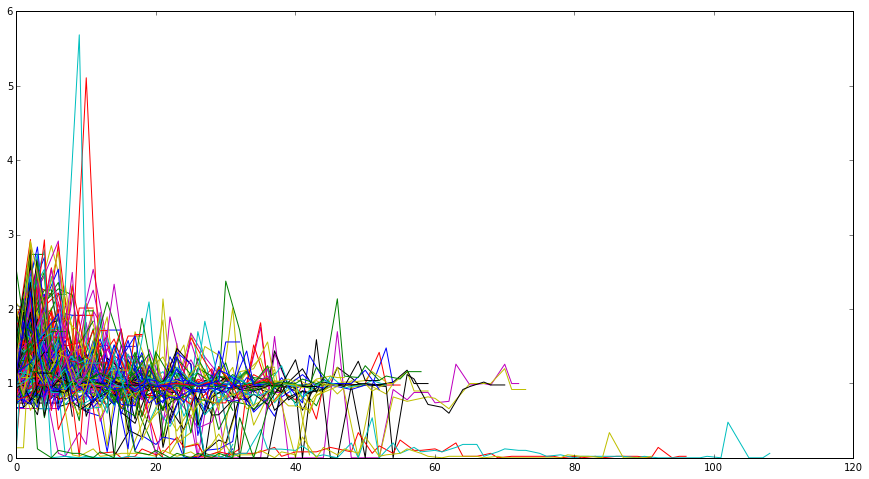

In [8]:
import matplotlib.pyplot as plt
import matplotlib #only needed to determine Matplotlib version number
from random import randint
import pylab

# Enable inline plotting
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
# Filter to remove containers with no informaction of the node, or to select specific nodes
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
for i in SnapshotDFFiltered.index:
  a = get_cpu_actual_use(i,snapshot_dataframe, snapshot_cpu_profile)
  plt.plot(a)

In [9]:
def load_application_mem_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_mem_virt_list = []
  container_mem_res_list = []
  container_mem_shr_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["memory_usage"]:
          # print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["memory_usage"]:
            container_capture_time = record["capture_time"]
            container_mem_virt = record["virt"]
            container_mem_res = record["res"]
            container_mem_shr = record["shr"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_mem_virt_list.insert(record_index,container_mem_virt)
            container_mem_res_list.insert(record_index,container_mem_res)
            container_mem_shr_list.insert(record_index,container_mem_shr)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_mem_virt_list,
                     container_mem_res_list,container_mem_shr_list))
  columns=[ 'timestamp','name','virt', 'res', 'shr']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_mem_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_mem_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_mem_profile, snapshot_failcount = load_snapshot_mem_profile(clustersnapshot_folders)
print ("Done! Loading %d profiles of %d containers, fail %d containers with no information" % 
       (len(snapshot_mem_profile.name.unique()),
        len(snapshot_mem_profile.name.unique()) + snapshot_failcount,
        snapshot_failcount))
snapshot_mem_profile

Done! Loading 268 profiles of 323 containers, fail 55 containers with no information


,timestamp,name,virt,res,shr
0,1456334839,container_e100_1456319042576_0003_01_000033,1869611008,85983232,18874368
1,1456334840,container_e100_1456319042576_0003_01_000033,1894776832,143654912,18874368
2,1456334842,container_e100_1456319042576_0003_01_000033,1900019712,715128832,19922944
3,1456334843,container_e100_1456319042576_0003_01_000033,1902116864,1073741824,19922944
4,1456334855,container_e100_1456319042576_0003_01_000043,1862270976,56623104,18874368
5,1456334857,container_e100_1456319042576_0003_01_000043,1870659584,103809024,18874368
6,1456334858,container_e100_1456319042576_0003_01_000043,1876951040,127926272,18874368
7,1456334860,container_e100_1456319042576_0003_01_000043,1883242496,352321536,19922944
8,1456334861,container_e100_1456319042576_0003_01_000043,1884291072,1073741824,19922944
9,1456334863,container_e100_1456319042576_0003_01_000043,1884291072,1181116006,19922944


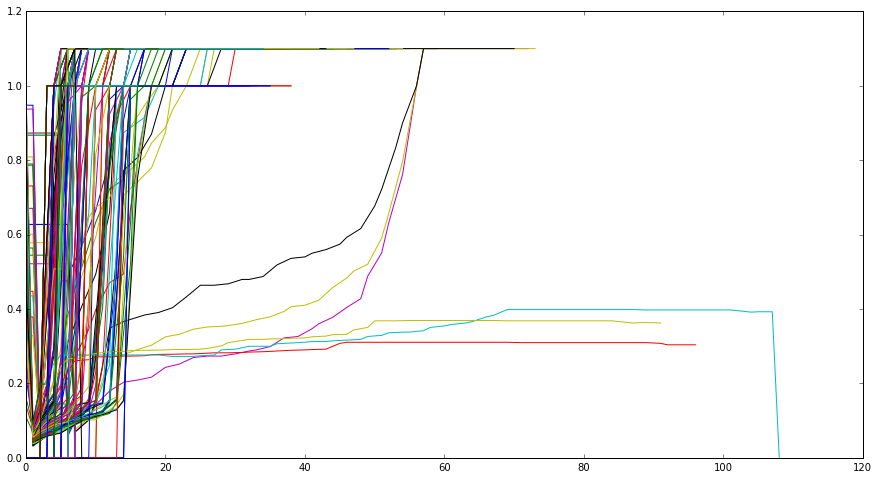

In [10]:
def get_mem_actual_use(container_name, snapshot_dataframe, snapshot_mem_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
  index = mem_container_filtered.timestamp.tolist()
  # get resident memory
  mem = mem_container_filtered.res.tolist()
  # get share memory
  #mem = mem_container_filtered.shr.tolist()
  # get virt memory
  #mem = mem_container_filtered.virt.tolist()
  container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    #print(a) # to see mismatch data point
    #raise Exception('Return length mismatch')
    
  return container_data4

# Filter to remove containers with no informaction of the node, or to select specific nodes
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
for container in SnapshotDFFiltered.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (1024*1024*1024) for x in mem_used ]
  plt.plot(mem_used)

## Normalize Memory and CPU Usage Pattern

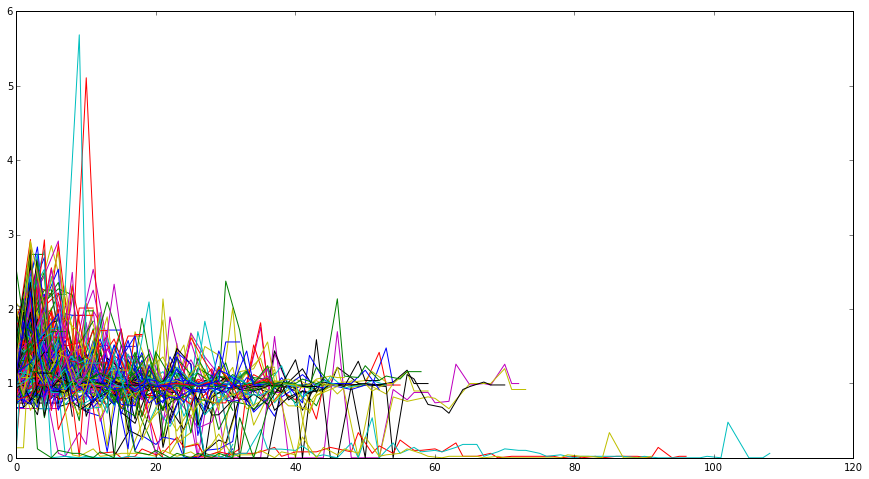

In [11]:
for container in SnapshotDFFiltered.index:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved mem
  plt.plot(cpu_usage)

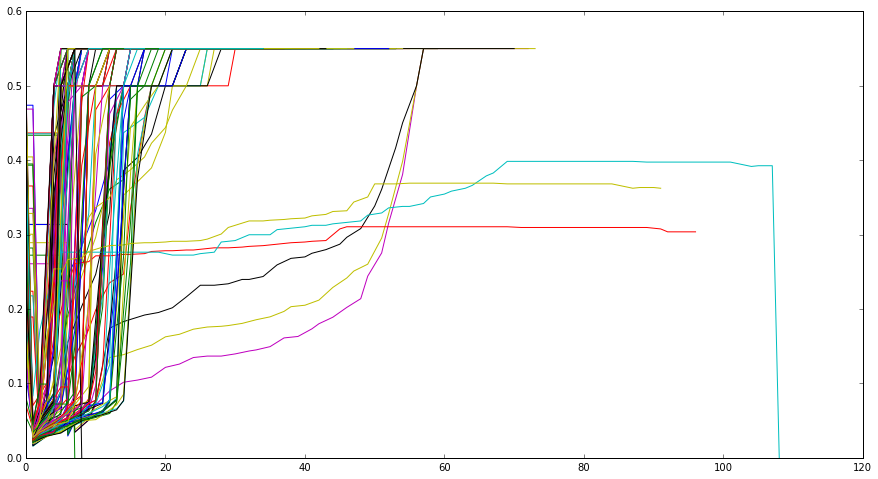

In [12]:
for container in SnapshotDFFiltered.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  plt.plot(mem_used)

## Build container list to run in simulator from real workload

## Simulation program

In [13]:
class container:
    'Common base class for all containers'
    conCount = 0
    
    def __init__(self, con_id, app_id, resv_memory, resv_CPU, duration):
        self.con_id = con_id
        self.app_id = app_id
        self.resv_memory = resv_memory
        self.resv_CPU = resv_CPU
        self.duration = duration
        container.conCount += 1
        
    def displayCount(self):
        print ("Total container: %d" % container.conCount)
    
    def displayContainer(self):
        print ("Container ID: %d" % self.con_id)
        print ("Application ID: %d" % self.app_id)
        print ("Container reserved memory (MBs): %d" % self.resv_memory)
        print ("Container reserved CPU (core): %d" % self.resv_CPU)
        print ("Container duration (second): %d" % self.duration)
    
    def getActualMemoryUsage(self):
        return 0
    
    def getActualMemoryUsage(self):
        return 0
        

In [14]:
class scheduler_queue:
    
    def __init__(self):
        self.queue = []
    
    def addToQueue(self, container):
        self.queue.append(container)
    
    def removeFromQueue(self, container):
        self.queue.remove(container)
    
    def popAtFirstPosition(self):
        self.queue.pop(0)
        
    def popAtLastPosition(self):
        self.queue.pop()
        
    def displayQueueContent(self):
        print ("There are %d containers in queue" % len(self.queue))
        for container in self.queue:
            print ("====== Container %d ======" % container.con_id)
            container.displayContainer()
    

In [15]:
class node:
    nodeCount = 0
    
    def __init__(self, Node_Name, Mem_Capacity, CPU_Capacity, Mem_Allow, CPU_Allow):
        self.Node_Name = Node_Name
        self.Mem_Capacity = Mem_Capacity
        self.CPU_Capacity = CPU_Capacity
        self.Mem_Allow = Mem_Allow
        self.CPU_Allow = CPU_Allow
        self.Mem_Allocated = 0
        self.CPU_Allocated = 0
        self.Mem_ActualUsed = 0
        self.CPU_ActualUsed = 0
        node.nodeCount += 1
    
    def displayNodeInfo(self):
        print ("Node Name: %s" % self.Node_Name)
        print ("Node Total Memory: %d" % self.Mem_Capacity)
        print ("Node Toal CPU %d" % self.CPU_Capacity)
        print ("Node Memory Allowable for Use: %d" % self.Mem_Allow)
        print ("Node CPU Allowable for Use: %d" % self.CPU_Allow)
        print ("Node Memory Allocated for Use: %d" % self.Mem_Allocated)
        print ("Node CPU Allocated for Use: %d" % self.CPU_Allocated)
        print ("Node Memory ActualUsage: %d" % self.Mem_ActualUsed)
        print ("Node CPU ActualUsage: %d" % self.CPU_ActualUsed)
        

In [16]:
class cluster:
    
    def __init__(self, cluster_name):
        self.cluster_name = cluster_name
        self.node_list = []
    
    def addNodeToCluster(self, node):
        self.node_list.append(node)
        
    def removeNodeFromCluster(self,node_name):
        node_index = -1
        for node in self.node_list:
            if node_name == node.Node_Name:
                node_index = self.node_list.index(node)
        if node_index >= 0: # Found node
            self.node_list.pop(node_index)
        else:
            raise Exception('Fail to find node in the cluster')
            
    def displayClusterInfo(self):
        total_mem = 0
        total_core = 0
        allow_mem = 0
        allow_core = 0
        print ("Cluster Name: %s" % self.cluster_name)
        print ("Number of nodes in cluster: %d" % len(self.node_list))
        for node in self.node_list:
            total_mem += node.Mem_Capacity
            total_core += node.CPU_Capacity
            allow_mem += node.Mem_Allow
            allow_core += node.CPU_Allow
        print ("Total Memory Capacity: %d" % total_mem)
        print ("Total CPU Capacity: %d" % total_core)
        print ("Total Memory allowable to use: %d" % allow_mem)
        print ("Total CPU allowable to use: %d" % allow_core)
    
    def displayNodeInfo(self):
        for node in self.node_list:
            print ("There are %d nodes in cluster %s" %(len(self.node_list), self.cluster_name))
            print ("=== node %s ===" % node.Node_Name)
            node.displayNodeInfo()

In [17]:
class scheduler:
    scheduler_name = "FIFO"
    
    def __init__(self, cluster, scheduler_queue):
        self.cluster = cluster
        self.scheduler_queue = scheduler_queue
    
    def executeContainer(self):
        

IndentationError: expected an indented block (<ipython-input-17-673dd81d587d>, line 9)

In [ ]:
class simulator:

In [18]:
con1 = container(1,1,1024,1,8)
con2 = container(2,1,2048,1,16)
queue = scheduler_queue()
queue.addToQueue(con1)
queue.addToQueue(con2)
queue.displayQueueContent()
queue.popAtFirstPosition()
queue.displayQueueContent()

There are 2 containers in queue
====== Container 1 ======
Container ID: 1
Application ID: 1
Container reserved memory (MBs): 1024
Container reserved CPU (core): 1
Container duration (second): 8
====== Container 2 ======
Container ID: 2
Application ID: 1
Container reserved memory (MBs): 2048
Container reserved CPU (core): 1
Container duration (second): 16
There are 1 containers in queue
====== Container 2 ======
Container ID: 2
Application ID: 1
Container reserved memory (MBs): 2048
Container reserved CPU (core): 1
Container duration (second): 16


In [ ]:
node1 = node( "svr01", 32768, 12, 28672, 10 )
node2 = node( "svr02", 32768, 12, 28672, 10 )
cluster = cluster("SPO")
cluster.addNodeToCluster(node1)
cluster.addNodeToCluster(node2)
cluster.displayClusterInfo()
cluster.displayNodeInfo()